# Kaggle March Madness 2016

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from time import time
from operator import itemgetter
from scipy.stats import randint as sp_randint
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import log_loss

from __future__ import division
from __future__ import print_function

%matplotlib inline

## Load and format data

In [3]:
# load data

results = pd.read_csv('data/ncaa_compiled_matchups.csv')
teams = pd.read_csv('data/Teams.csv')
kenpom = pd.read_csv('data/kenpom_sql.csv')
seeds = pd.read_csv('data/TourneySeeds.csv')
massey = pd.read_csv('data/massey.csv')

teams.columns = ['Team','Team_Name']
seeds = pd.merge(seeds, teams, how='left')
seeds.columns = ['Season','Seed','Team_id','Team_Name']

kenpom['Team'] = kenpom['Team'].str.strip()
massey_pivot = pd.pivot_table(massey, index=['season','team'], columns='sys_name', values='orank', fill_value=999).reset_index()

## Merge matchups and external stats

In [7]:
def merge_data(team_names, matchups, stats, ljoin = ['Season','Team_Name'], rjoin = ['Year','Team'], training_set=True):
    """Merge a dataset matchups with ['Season','Wteam','Lteam'] to kenpom and massey"""
    
    merged_stats = pd.merge(team_names, stats, left_on=ljoin, right_on=rjoin)
    join1 = pd.merge(matchups, merged_stats, left_on=['Season','Wteam'], right_on=['Season','Team_id'])
    output = pd.merge(join1, merged_stats, left_on=['Season','Lteam'], right_on=['Season','Team_id'])
    
    # feature engineering
    
    output['win_pyth'] = output['Wins_x'] ** 2 / (output['Wins_x'] ** 2 + output['Wins_y'] ** 2)
    
    if training_set:
        output['score_diff'] = output['Wscore'] - output['Lscore']
    
    print('Matchups shape: %s' %(matchups[matchups.Season > 2002].shape,))
    print('Merged stats shape: %s' %(merged_stats.shape,))
    print('Output shape: %s' %(output[output.Season > 2002].shape,))
    
    massey1 = pd.merge(output, massey_pivot, left_on=['Season','Wteam'], right_on=['season','team'])
    output_massey = pd.merge(massey1, massey_pivot, left_on=['Season','Lteam'], right_on=['season','team'])

    output_massey = diff_columns(output_massey, pd.unique(massey.sys_name))
    output_massey = diff_columns(output_massey, kenpom_columns)
    
    return output_massey

def diff_columns(d, cols):
    for metric in cols:
        new_col = metric + '_diff'
        x_col = metric + '_x'
        y_col = metric + '_y'
        d[new_col] = d[x_col] - d[y_col]
    return d

kenpom_columns = kenpom.columns[4:6] | kenpom.columns[7:]
results_merged_massey = merge_data(seeds, results.dropna(), kenpom)

print('Final output shape: %s' %(results_merged_massey.shape,))

columns_to_keep = ['Season','Wteam','Lteam','win_pyth'] + \
                    [metric + '_diff' for metric in kenpom_columns] + \
                    [metric + '_diff' for metric in ['WLK','POM','MOR','WOL','SAG','USA',\
                                                     'RPI','COL','RTH','GRN','BOB','DOL','CNG']] + \
                    ['score_diff']



Matchups shape: (1694, 8)
Merged stats shape: (924, 28)
Output shape: (1692, 64)
Final output shape: (1692, 462)


## Random forest classifier

In [ ]:
def prepare_datasets(raw_data, columns_keep, season_cutoff, stochastic=False, training_set=True):
    intermediate = raw_data[columns_keep]
    
    if stochastic:
        index = np.random.permutation(raw_data.shape[0])
        training_size = raw_data.shape[0] // 10 * 9

        data_for_training = intermediate.iloc[index,:]

        train_set = intermediate[:training_size]
        test_set = intermediate[training_size:]

    else:
        data_for_training = intermediate[intermediate.Season < season_cutoff]

        train_set = intermediate[intermediate.Season < season_cutoff]
        test_set = intermediate[intermediate.Season >= season_cutoff]

    trd = train_set.iloc[:,5:-1]
    trl = train_set.iloc[:,-1]

    ttd = test_set.iloc[:,5:-1]
    ttl = test_set.iloc[:,-1]

    print('Training data shape: %s' %(trd.shape,))
    print('Training labels shape: %s' %(trl.shape,))
    print('Test data shape: %s' %(ttd.shape,))
    print('Test labels shape: %s' %(ttl.shape,))
    
    return trd, trl, ttd, ttl

training_data, training_labels, \
        test_data, test_labels = prepare_datasets(results_merged_massey, columns_to_keep, 2012, stochastic=False)

params = {'bootstrap': True
          ,'criterion': 'entropy'
          ,'n_estimators': 5000
          ,'n_jobs': -1
         }

clf = RandomForestClassifier(**params)
clf.fit(training_data, training_labels > 0)
predicted_scores = clf.predict(test_data)

predicted_probs = clf.predict_proba(test_data)


**Leaderboard rating: 0.3874**

Model accuracy of 0.849

Feature Importances:



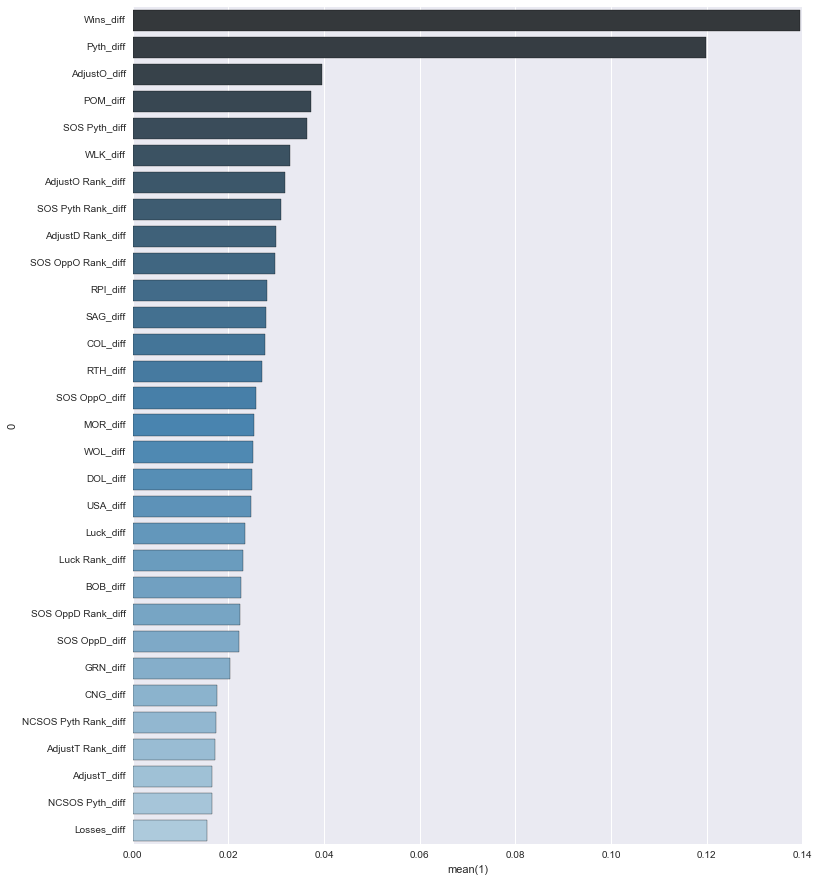

In [14]:
print('\n**Leaderboard rating: %.4f**'%(log_loss(test_labels > 0, predicted_probs[:,1], eps=0.04)))

print('\nModel accuracy of %.3f\n\nFeature Importances:\n' 
      %np.mean(predicted_scores == (test_labels > 0).values))

feat_import = sorted(zip(test_data.columns, clf.feature_importances_), key=lambda tup: tup[1], reverse=True)

plt.figure(figsize=(12,15))
ax = sns.barplot(pd.DataFrame(feat_import)[1], pd.DataFrame(feat_import)[0], orient="h", palette='Blues_d')

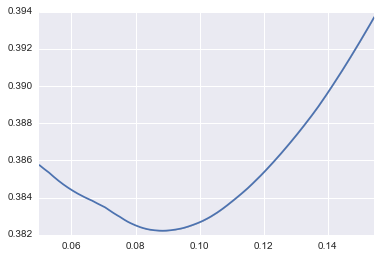

In [25]:

epsilons = [x/2000 for x in range(100,310)]
ratings = [log_loss(test_labels > 0, predicted_probs[:,1], eps=clip) for clip in epsilons]


ax = sns.tsplot(ratings, epsilons)


## Grid search for hyperparameters

In [107]:
# Utility function to report best scores
def report(grid_scores, n_top=3):
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")


clf = RandomForestClassifier(n_estimators=50)
# specify parameters and distributions to sample from
param_dist = {"max_depth": [3, 5, 7, 9, 11, None]
              ,"max_features": range(5, 15, 2)
              ,"min_samples_split": range(5, 15, 2)
              ,"min_samples_leaf": range(5, 15, 2)
              }

# run randomized search
random_search = GridSearchCV(clf, param_grid=param_dist,verbose=1)

start = time()
random_search.fit(cv_data, cv_labels)

report(random_search.grid_scores_)

[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:   10.5s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:   45.8s
[Parallel(n_jobs=1)]: Done 449 tasks       | elapsed:  1.9min
[Parallel(n_jobs=1)]: Done 799 tasks       | elapsed:  4.0min
[Parallel(n_jobs=1)]: Done 1249 tasks       | elapsed:  7.1min
[Parallel(n_jobs=1)]: Done 1799 tasks       | elapsed: 11.7min


Fitting 3 folds for each of 750 candidates, totalling 2250 fits
Model with rank: 1
Mean validation score: 0.061 (std: 0.012)
Parameters: {'max_features': 5, 'min_samples_split': 5, 'max_depth': 9, 'min_samples_leaf': 9}

Model with rank: 2
Mean validation score: 0.060 (std: 0.013)
Parameters: {'max_features': 5, 'min_samples_split': 11, 'max_depth': 11, 'min_samples_leaf': 7}

Model with rank: 3
Mean validation score: 0.059 (std: 0.023)
Parameters: {'max_features': 5, 'min_samples_split': 9, 'max_depth': 9, 'min_samples_leaf': 5}



[Parallel(n_jobs=1)]: Done 2250 out of 2250 | elapsed: 15.9min finished


## Generate Scoring File

In [ ]:
sub_matchups = pd.read_csv('data/submission_file.csv')

columns_to_keep_final = [x for x in columns_to_keep if x not in ['Wscore','Lscore','score_diff']]
submission_file = merge_data(seeds, sub_matchups, kenpom, training_set=False)[columns_to_keep_final]
submission_file_data = submission_file.iloc[:,5:]

print('Final submission test data shape: %s' %(submission_file_data.shape,))

def ftostr(x):
    return str(int(x))

predicted_scores_final = clf.predict_proba(submission_file_data)
epsilon = 0.09
predicted_scores_final = np.clip(predicted_scores_final, epsilon, 1 - epsilon)

submission_file['id'] = submission_file.apply(lambda x: ftostr(x.Season) + '_' + ftostr(x.Wteam) + '_' + ftostr(x.Lteam), axis=1)

submission_output = pd.DataFrame(zip(submission_file.id, predicted_scores_final[:,1]), columns=['id','pred'])

submission_output.to_csv('submission.csv', index=False)

Matchups shape: (9112, 3)
Merged stats shape: (924, 28)
Output shape: (9112, 58)
Final submission test data shape: (9112, 31)

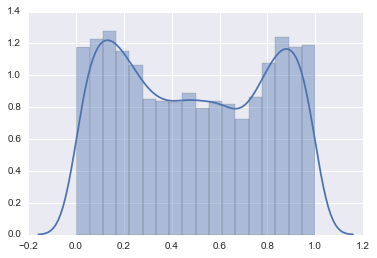

In [150]:
sns.distplot(predicted_scores_final[:,1])